In [1]:
import pandas as pd
import numpy as np
# https://www.kaggle.com/code/carlmcbrideellis/feature-selection-using-the-boruta-shap-package
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import random
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier


In [2]:
data = pd.read_csv("data_with_new_features.csv")
features = pd.read_csv('feature_importances_xgb.csv', nrows = 20)
features.head()
selected_features = list[features['Unnamed: 0'].values]
selected_features

list[array(['months_employed', 'credit_score', 'age', 'interest_rate',
       'credit_age_factor', 'dtiratio', 'interest_payment_burden',
       'income_to_interest_ratio', 'credit_income_inter',
       'income_to_loan_ratio', 'loan_pay_to_inc_ratio', 'loan_amount',
       'empl_sta', 'credit_util_ratio', 'income', 'has_co_signer=No',
       'employment_type=Full-time', 'loan_term',
       'employment_type=Unemployed', 'has_dependents=No'], dtype=object)]

In [3]:
data_new = data.copy()
y = data_new["default"]
del data_new["default"]

data_new = data_new[selected_features]

In [4]:
df_full_train, df_test, y_full_train, y_test = train_test_split(data_new, y, stratify = y, test_size = 0.2, random_state = 1)

df_train, df_val, y_train, y_val = train_test_split(df_full_train, y_full_train, stratify =y_full_train,  test_size = 0.25, random_state = 1)

In [5]:
df_full_train = df_full_train.reset_index(drop = True)
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

In [6]:
y_full_train = y_full_train.values
y_train = y_train.values
y_val = y_val.values
y_test = y_test.values

In [7]:
full_train_dicts = df_full_train.to_dict(orient = 'records')
train_dicts = df_train.to_dict(orient = 'records')
val_dicts = df_val.to_dict(orient = 'records')
test_dicts = df_test.to_dict(orient = 'records')

In [8]:
# I was getting a memory error, so I set sparse=True for the DictVectorizer.
dv = DictVectorizer(sparse = True)
dv.fit(train_dicts)
X_full_train_new = dv.transform(full_train_dicts)
X_train_new = dv.transform(train_dicts)
X_val_new = dv.transform(val_dicts)
X_test_new = dv.transform(test_dicts)

In [9]:



from sklearn.utils.class_weight import compute_sample_weight

sample_weights = compute_sample_weight(class_weight='balanced', y=y_full_train)

In [10]:
# fit model no training data
model = XGBClassifier(params = {'subsample': 0.9, 'scale_pos_weight': 1, 'reg_lambda': 1,'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 5,
'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.9}, objective="binary:logistic", feature_name=dv.get_feature_names_out(), random_state = 1)
model.fit(X_full_train_new, y_full_train,sample_weight=sample_weights)

C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:41:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "feature_name", "params" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              feature_name=array(['age', 'credit_age_factor', 'credit_income_inter', ...,
       'marital_status_dependents=Single_Yes', 'months_employed',
       'num_credit_lin...
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [11]:
y_pred = model.predict_proba(X_test_new)[:,1]

In [12]:
print(y_pred)

[0.75899124 0.67681766 0.54432464 ... 0.37157747 0.14638917 0.1884372 ]


In [13]:
y_pred > 0.5
y_decision = (y_pred >= 0.5).astype(int)
acc = (y_test == y_decision).mean().round(2)
print(f"Accuracy is calculated as \033[1m{acc}\033[0m.")
f_macro = f1_score(y_test, y_decision, average='macro').round(2)
print(f"Macro F1 score is calculated as \033[1m{f_macro}\033[0m.")
f_weighted = f1_score(y_test, y_decision, average='weighted').round(2)
print(f"Weighted F1 score is calculated as \033[1m{f_weighted}\033[0m.")

Accuracy is calculated as 0.71.
Macro F1 score is calculated as 0.58.
Weighted F1 score is calculated as 0.76.


In [14]:
seeds = [5, 13, 29, 43, 57, 87, 29, 42,1, 93]

In [15]:
#I initiannly get same results for each run. I tried the change subsample, colsample_bytree parameters but it did not help.
#To devaluate non deterministic results I st booster to gblinear readinf the xgboost documentation 
#https://readthedocs.org/projects/xgboost/downloads/pdf/latest/

results = []
for i in [5, 13, 29, 43, 57, 87, 28, 42,1, 93]:
    print(i)
    # I have deleted subsample and colsample_bytree parameters since I have evaluated same result at each run
    model = XGBClassifier(params = {'subsample': 0.9, 'scale_pos_weight': 1, 'reg_lambda': 1,'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 5,
'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.9}, objective="binary:logitraw", feature_selector= "shuffle", booster = 'gblinear',
                          feature_name=dv.get_feature_names_out(), random_state = i)
    model.fit(X_full_train_new, y_full_train,sample_weight=sample_weights)
    y_pred = model.predict_proba(X_test_new)[:,1]
    y_pred > 0.5
    y_decision = (y_pred >= 0.5).astype(int)
    acc = (y_test == y_decision).mean().round(4)
    print(f"Accuracy is calculated as \033[1m{acc}\033[0m.")
    f_macro = f1_score(y_test, y_decision, average='macro').round(4)
    print(f"Macro F1 score is calculated as \033[1m{f_macro}\033[0m.")
    f_weighted = f1_score(y_test, y_decision, average='weighted').round(4)
    print(f"Weighted F1 score is calculated as \033[1m{f_weighted}\033[0m.")
    results.append((acc,f_macro,f_weighted))
    output_file = f'modelxgb_i={i}.bin'
    with open(output_file, 'wb') as f_out:
        pickle.dump((dv, model), f_out)
    

5


C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:41:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "feature_name", "params" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy is calculated as 0.7998.
Macro F1 score is calculated as 0.6243.
Weighted F1 score is calculated as 0.8214.
13


C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:41:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "feature_name", "params" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy is calculated as 0.8005.
Macro F1 score is calculated as 0.6245.
Weighted F1 score is calculated as 0.8219.
29


C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:41:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "feature_name", "params" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy is calculated as 0.7998.
Macro F1 score is calculated as 0.6245.
Weighted F1 score is calculated as 0.8215.
43


C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:42:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "feature_name", "params" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy is calculated as 0.7994.
Macro F1 score is calculated as 0.6241.
Weighted F1 score is calculated as 0.8212.
57


C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:42:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "feature_name", "params" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy is calculated as 0.7994.
Macro F1 score is calculated as 0.6242.
Weighted F1 score is calculated as 0.8212.
87


C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:42:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "feature_name", "params" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy is calculated as 0.8001.
Macro F1 score is calculated as 0.6245.
Weighted F1 score is calculated as 0.8217.
28


C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:42:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "feature_name", "params" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy is calculated as 0.7998.
Macro F1 score is calculated as 0.6237.
Weighted F1 score is calculated as 0.8214.
42


C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:42:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "feature_name", "params" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy is calculated as 0.8004.
Macro F1 score is calculated as 0.6247.
Weighted F1 score is calculated as 0.8218.
1


C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:42:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "feature_name", "params" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy is calculated as 0.8.
Macro F1 score is calculated as 0.6246.
Weighted F1 score is calculated as 0.8216.
93


C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:42:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "feature_name", "params" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy is calculated as 0.8002.
Macro F1 score is calculated as 0.6245.
Weighted F1 score is calculated as 0.8217.


In [16]:
import pickle

from flask import Flask
from flask import request
from flask import jsonify


model_file1 = 'modelxgb_i=5.bin'

with open(model_file1, 'rb') as f_in:
    dv1, model1 = pickle.load(f_in)

est1 = model1.predict_proba(X_test_new)

model_file2 = 'modelxgb_i=13.bin'

with open(model_file2, 'rb') as f_in:
    dv2, model2 = pickle.load(f_in)

est2 = model2.predict_proba(X_test_new)

model_file3 = 'modelxgb_i=29.bin'

with open(model_file3, 'rb') as f_in:
    dv3, model3 = pickle.load(f_in)

est3 = model3.predict_proba(X_test_new)


model_file4 = 'modelxgb_i=43.bin'

with open(model_file4, 'rb') as f_in:
    dv4, model4 = pickle.load(f_in)

est4 = model4.predict_proba(X_test_new)


model_file5 = 'modelxgb_i=57.bin'

with open(model_file5, 'rb') as f_in:
    dv5, model5 = pickle.load(f_in)

est5 = model5.predict_proba(X_test_new)



model_file6 = 'modelxgb_i=87.bin'

with open(model_file6, 'rb') as f_in:
    dv6, model6 = pickle.load(f_in)

est6 = model6.predict_proba(X_test_new)


model_file7 = 'modelxgb_i=28.bin'

with open(model_file7, 'rb') as f_in:
    dv7, model7 = pickle.load(f_in)

est7 = model7.predict_proba(X_test_new)


model_file8 = 'modelxgb_i=42.bin'

with open(model_file8, 'rb') as f_in:
    dv8, model8 = pickle.load(f_in)

est8 = model8.predict_proba(X_test_new)


model_file9 = 'modelxgb_i=1.bin'

with open(model_file9, 'rb') as f_in:
    dv9, model9 = pickle.load(f_in)

est9 = model9.predict_proba(X_test_new)

model_file10 = 'modelxgb_i=93.bin'

with open(model_file10, 'rb') as f_in:
    dv10, model10 = pickle.load(f_in)

est10 = model10.predict_proba(X_test_new)

In [17]:
list_models = np.array([est1, est2, est3, est4, est5, est6, est7, est8, est9, est10])
averages = np.average(list_models, axis=0)


Accuracy is calculated as 0.8.
Macro F1 score is calculated as 0.6245.
Weighted F1 score is calculated as 0.8216.


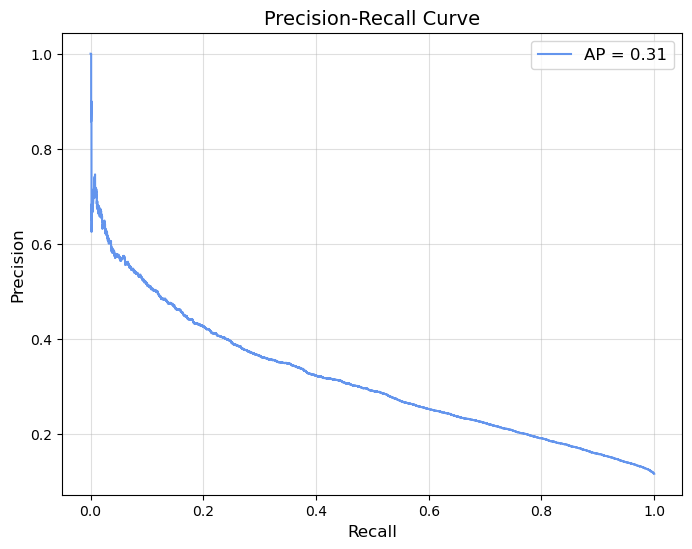

In [18]:
y_pred_proba = est1
y_pred =averages[:,1]
y_pred > 0.5
y_decision = (y_pred >= 0.5).astype(int)
acc = (y_test == y_decision).mean().round(4)
print(f"Accuracy is calculated as \033[1m{acc}\033[0m.")
f_macro = f1_score(y_test, y_decision, average='macro').round(4)
print(f"Macro F1 score is calculated as \033[1m{f_macro}\033[0m.")
f_weighted = f1_score(y_test, y_decision, average='weighted').round(4)
print(f"Weighted F1 score is calculated as \033[1m{f_weighted}\033[0m.")
results.append((acc,f_macro,f_weighted))

# Calculate precision and recall values for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Calculate the average precision score
average_precision = average_precision_score(y_test, y_pred)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AP = {average_precision:.2f}', color = "cornflowerblue")
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(alpha=0.4)
plt.show()


In [19]:
xgboost = pd.DataFrame(data = results,columns = ['accuracy', 'f_macro', 'f_weighted'])

xgboost.to_csv('xgboost_results.csv')

# Random Forest Classifier

In [20]:

results = []
for i in [5, 13, 29, 43, 57, 87, 28, 42,1, 93]:
    print(i)
    # I have deleted subsample and colsample_bytree parameters since I have evaluated same result at each run
    model = RandomForestClassifier(oob_score =  False, n_estimators =  500, min_samples_split = 10, min_samples_leaf = 1, max_samples =  0.9, max_features = 'sqrt', max_depth =  40, class_weight = 'balanced',
                                   bootstrap = True, n_jobs = -1,random_state = i)
    model.fit(X_full_train_new, y_full_train)
    y_pred = model.predict_proba(X_test_new)[:,1]
    y_pred > 0.5
    y_decision = (y_pred >= 0.5).astype(int)
    acc = (y_test == y_decision).mean().round(4)
    print(f"Accuracy is calculated as \033[1m{acc}\033[0m.")
    f_macro = f1_score(y_test, y_decision, average='macro').round(4)
    print(f"Macro F1 score is calculated as \033[1m{f_macro}\033[0m.")
    f_weighted = f1_score(y_test, y_decision, average='weighted').round(4)
    print(f"Weighted F1 score is calculated as \033[1m{f_weighted}\033[0m.")
    results.append((acc,f_macro,f_weighted))
    output_file = f'modelrf_i={i}.bin'
    with open(output_file, 'wb') as f_out:
        pickle.dump((dv, model), f_out)
    

5
Accuracy is calculated as 0.7194.
Macro F1 score is calculated as 0.5779.
Weighted F1 score is calculated as 0.7655.
13
Accuracy is calculated as 0.7222.
Macro F1 score is calculated as 0.5788.
Weighted F1 score is calculated as 0.7675.
29
Accuracy is calculated as 0.7293.
Macro F1 score is calculated as 0.5824.
Weighted F1 score is calculated as 0.7725.
43
Accuracy is calculated as 0.7215.
Macro F1 score is calculated as 0.5784.
Weighted F1 score is calculated as 0.767.
57
Accuracy is calculated as 0.7225.
Macro F1 score is calculated as 0.5807.
Weighted F1 score is calculated as 0.7679.
87
Accuracy is calculated as 0.7259.
Macro F1 score is calculated as 0.5805.
Weighted F1 score is calculated as 0.7701.
28
Accuracy is calculated as 0.7275.
Macro F1 score is calculated as 0.5815.
Weighted F1 score is calculated as 0.7713.
42
Accuracy is calculated as 0.7254.
Macro F1 score is calculated as 0.5807.
Weighted F1 score is calculated as 0.7698.
1
Accuracy is calculated as 0.7201.
Macro 

In [21]:
randomfor = pd.DataFrame(data = results,columns = ['accuracy', 'f_macro', 'f_weighted'])

randomfor.to_csv('randomforest_results.csv')

# Logistic Regression 

In [22]:
from sklearn.linear_model import LogisticRegression
results = []
for i in [5, 13, 29, 43, 57, 87, 28, 42,1, 93]:
    print(i)
    # I have deleted subsample and colsample_bytree parameters since I have evaluated same result at each run
    model = LogisticRegression(class_weight='balanced', random_state = i, solver = 'liblinear', penalty = 'l2', max_iter =500, C = 1, n_jobs = -1)
    model.fit(X_full_train_new, y_full_train)
    y_pred = model.predict_proba(X_test_new)[:,1]
    y_pred > 0.5
    y_decision = (y_pred >= 0.5).astype(int)
    acc = (y_test == y_decision).mean().round(4)
    print(f"Accuracy is calculated as \033[1m{acc}\033[0m.")
    f_macro = f1_score(y_test, y_decision, average='macro').round(4)
    print(f"Macro F1 score is calculated as \033[1m{f_macro}\033[0m.")
    f_weighted = f1_score(y_test, y_decision, average='weighted').round(4)
    print(f"Weighted F1 score is calculated as \033[1m{f_weighted}\033[0m.")
    results.append((acc,f_macro,f_weighted))
    output_file = f'modellog_i={i}.bin'
    with open(output_file, 'wb') as f_out:
        pickle.dump((dv, model), f_out)
    

5


C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Accuracy is calculated as 0.6247.
Macro F1 score is calculated as 0.5102.
Weighted F1 score is calculated as 0.692.
13


C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Accuracy is calculated as 0.6247.
Macro F1 score is calculated as 0.5102.
Weighted F1 score is calculated as 0.692.
29


C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Accuracy is calculated as 0.6247.
Macro F1 score is calculated as 0.5102.
Weighted F1 score is calculated as 0.692.
43


C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Accuracy is calculated as 0.6247.
Macro F1 score is calculated as 0.5102.
Weighted F1 score is calculated as 0.692.
57


C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Accuracy is calculated as 0.6247.
Macro F1 score is calculated as 0.5102.
Weighted F1 score is calculated as 0.692.
87


C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Accuracy is calculated as 0.6247.
Macro F1 score is calculated as 0.5102.
Weighted F1 score is calculated as 0.692.
28


C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Accuracy is calculated as 0.6247.
Macro F1 score is calculated as 0.5102.
Weighted F1 score is calculated as 0.692.
42


C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Accuracy is calculated as 0.6247.
Macro F1 score is calculated as 0.5102.
Weighted F1 score is calculated as 0.692.
1


C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Accuracy is calculated as 0.6247.
Macro F1 score is calculated as 0.5102.
Weighted F1 score is calculated as 0.692.
93


C:\Users\Kuzey\Anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Accuracy is calculated as 0.6247.
Macro F1 score is calculated as 0.5102.
Weighted F1 score is calculated as 0.692.


In [23]:
logreg = pd.DataFrame(data = results,columns = ['accuracy', 'f_macro', 'f_weighted'])

logreg.to_csv('logreg_results.csv')

In [24]:
a = pd.read_csv('logreg_results.csv')
a.head()

,Unnamed: 0,accuracy,f_macro,f_weighted
0,0,0.6247,0.5102,0.692
1,1,0.6247,0.5102,0.692
2,2,0.6247,0.5102,0.692
3,3,0.6247,0.5102,0.692
4,4,0.6247,0.5102,0.692
